In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

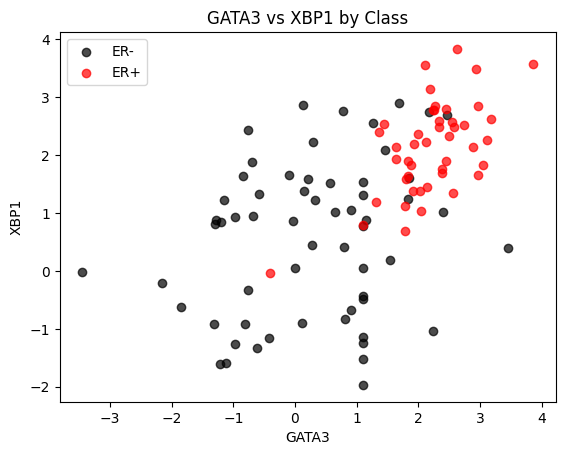

In [32]:
# here I load data, their class labels and gene metadata
d = pd.read_csv("./data/filtered.tsv", sep="\t")
c = pd.read_csv("./data/class.tsv", sep="\t", header=None)
g = pd.read_csv("./data/columns.tsv", sep="\t", comment="#")

# finding column names — leading space caused lots of issues initially :)
g1 = " " + str(g.loc[g['GeneSymbol'] == 'GATA3', 'ID'].values[0])
g2 = " " + str(g.loc[g['GeneSymbol'] == 'XBP1', 'ID'].values[0])

x = d[g1].values
y = d[g2].values
z = c[0].values

# masks for ER- and ER+
m0 = (z == 0)
m1 = (z == 1)

plt.scatter(x[m0], y[m0], c='k', alpha=0.7, label='ER-')
plt.scatter(x[m1], y[m1], c='r', alpha=0.7, label='ER+')
plt.xlabel("GATA3")
plt.ylabel("XBP1")
plt.title("GATA3 vs XBP1 by Class")
plt.legend()
plt.show()

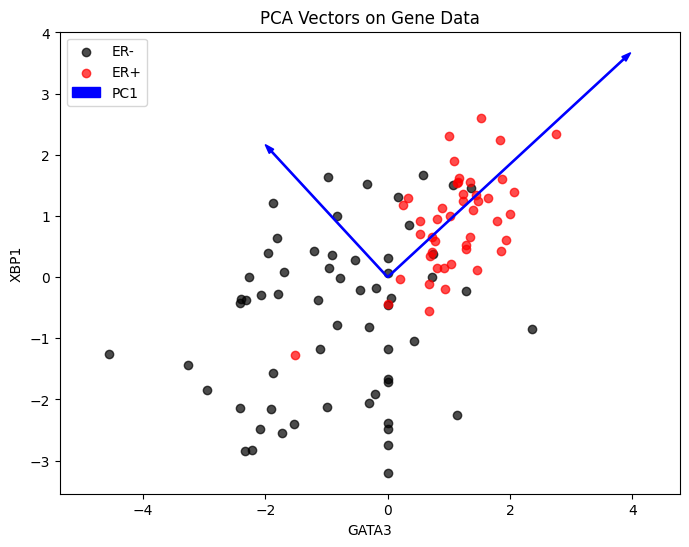

In [33]:
# stacking reqd cols into a 2D point array
pts = np.vstack((x, y)).T

# recentering about origin
mean = pts.mean(axis=0)
pts_c = pts - mean

cov = np.cov(pts_c.T)
eig_vals, eig_vecs = np.linalg.eig(cov)

# sorting e-values and their e-vectors (desc order of imp)
idx = np.argsort(eig_vals)[::-1]
eig_vals = eig_vals[idx]
eig_vecs = eig_vecs[:, idx]

vecs = eig_vecs.T
var = eig_vals

# reusing the same masks here as well for coloring
m0 = (z == 0)
m1 = (z == 1)

plt.figure(figsize=(8, 6))
plt.scatter(pts_c[m0, 0], pts_c[m0, 1], c='k', alpha=0.7, label='ER-')
plt.scatter(pts_c[m1, 0], pts_c[m1, 1], c='r', alpha=0.7, label='ER+')

# drawing arrows for PCA scaled by std. dev.
for i in range(2):
    plt.arrow(0, 0,
              vecs[i, 0] * np.sqrt(var[i]) * 3,
              vecs[i, 1] * np.sqrt(var[i]) * 3,
              color='b', width=0.02, head_width=0.1,
              label=f'PC{i+1}' if i == 0 else None)

plt.xlabel("GATA3") # centered
plt.ylabel("XBP1")  # centered
plt.title("PCA Vectors on Gene Data")
plt.legend()
plt.axis('equal')
plt.show()


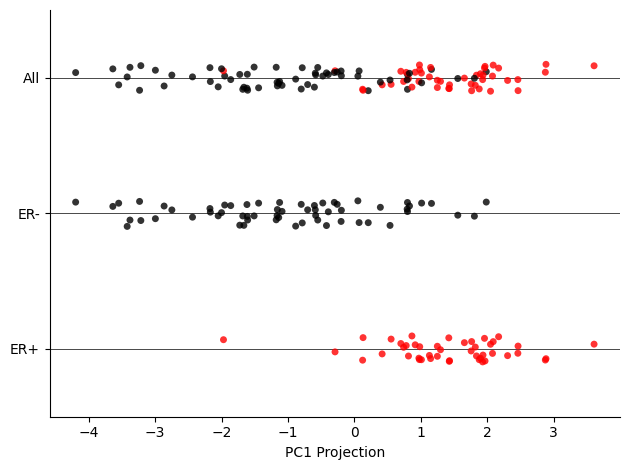

In [34]:
# now projecting data onto first component
pc1 = np.dot(pts_c, eig_vecs[:, 0])

# create DataFrames for combined, ER-, and ER+ resp
df_all = pd.DataFrame({"PC1": pc1, "Grp": "All", "Clr": np.where(z == 0, "k", "r")})
df_neg = pd.DataFrame({"PC1": pc1[z == 0], "Grp": "ER-", "Clr": "k"})
df_pos = pd.DataFrame({"PC1": pc1[z == 1], "Grp": "ER+", "Clr": "r"})

df_plot = pd.concat([df_all, df_neg, df_pos], ignore_index=True) # to plot

ax = sns.stripplot(data=df_plot, x="PC1", y="Grp", hue="Clr",
                   palette={"k": "black", "r": "red"},
                   dodge=False, jitter=True, alpha=0.8, size=5)

ax.yaxis.grid(True, linestyle='-', color='black', linewidth=0.5)
plt.xlabel("PC1 Projection")
plt.ylabel("")
plt.legend([], [], frameon=False)
sns.despine()
plt.tight_layout()
plt.show()


my observations:

- ER+ (red) and ER− (black) samples separate quite well along first component.
- ER+ cluster on right (+ve PC1) while ER− on left.
- very few outliers (variation or perhaps noise), PC1 is really dominating.